# Initial imports

In [3]:
pd.__version__

'0.25.0'

In [2]:
# Numeric and data processing
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas.api.types import CategoricalDtype

# sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.metrics import cohen_kappa_score, f1_score, classification_report, matthews_corrcoef, make_scorer
from scipy.stats import ks_2samp
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterGrid
from sklearn.feature_selection import SelectFromModel, VarianceThreshold, chi2, SelectKBest

# Hyperopt
from hyperopt import fmin, hp, tpe, rand, Trials, space_eval, STATUS_OK, anneal
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
import scikitplot as skplt
import seaborn as sns

# lightgbm
import lightgbm as lgb

# Misc
import tqdm
import time


In [3]:
# Global random state for reproducibility
random_state_global = 42

# Dataprep

## Reading data from csv

8. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

In [5]:
df_full = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';', na_values=['unknown'])
df_full.columns = df_full.columns.str.replace('.', '_')

In [6]:
df_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [8]:
# Is there missing values on data? YES, I forced it using a_values=['unknown'] 
df_full.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

## Categorical and numeric data preprocessing

## Categorical data

Some categorical have a meaningful ordering, like education ('basic.4y' < 'basic.6y',  ...) and default ('yes' > 'no'). For these
we will use this information while creating the category data type; for the others, there is no meaningful order, and we will not specify order while creating the category data type.

In [9]:
# Frequency of categories for each categorical feature
for col in df_full.select_dtypes('O').columns:
    print('\n', col)
    print(df_full[col].value_counts(dropna=False))


 job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
NaN                330
Name: job, dtype: int64

 marital
married     24928
single      11568
divorced     4612
NaN            80
Name: marital, dtype: int64

 education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
NaN                     1731
illiterate                18
Name: education, dtype: int64

 default
no     32588
NaN     8597
yes        3
Name: default, dtype: int64

 housing
yes    21576
no     18622
NaN      990
Name: housing, dtype: int64

 loan
no     33950
yes     6248
NaN      990
Name: loan, dtype: int64

 contact
cellular     26144
telephone    15044
Name: contact, dtype: int64

 month
m

## Downcasting numeric features to reduce memory usage
(inspired on https://www.kaggle.com/gemartin/load-data-reduce-memory-usage)

In [10]:
# Dict storing datatypes of all features
dict_dtypes = {}

# Categorical features with meaningful ordering
dict_dtypes['education'] = CategoricalDtype(categories = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 
                                                          'professional.course', 'university.degree']
                                            , ordered=True)

dict_dtypes['default'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['housing'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['loan'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)
dict_dtypes['poutcome'] = CategoricalDtype(categories = ['failure', 'success'], ordered=True)# nonexistent considered as missing value
dict_dtypes['y'] = CategoricalDtype(categories = ['no', 'yes'], ordered=True)

# Polemic
dict_dtypes['day_of_week'] = CategoricalDtype(categories = ['mon', 'tue', 'wed', 'thu', 'fri'], ordered=True)
dict_dtypes['month'] = CategoricalDtype(categories = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug',
                                                     'sep', 'oct', 'nov', 'dec'], ordered=True)
# Other categorical features
for col in df_full.select_dtypes('O').columns:
    if col not in dict_dtypes.keys():
        dict_dtypes[col] = CategoricalDtype(categories = sorted(df_full[col].dropna().unique()), ordered=False)

In [11]:
# Note: pandas alerady have nullable integer datatypes, but I will not use. If a integer column have at least a missing value,
# it will be converted to float32.
for col in tqdm.tqdm(df_full.select_dtypes(np.number).columns, position=0, desc='Reducing memory usage for numeric columns'):
    _vec_min_max = df_full[col].describe()[['min','max']]
    _has_null = df_full[col].isnull().max()
    _has_float = (df_full[col] % 1 != 0).any()
    
    if _has_float or _has_null:
        dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='float').dtype
    else:
        if _vec_min_max[0] >=0:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='unsigned').dtype
        else:
            dict_dtypes[col] = pd.to_numeric(_vec_min_max, downcast='signed').dtype

start_memory_usage = df_full.memory_usage().sum() / 1024**2
end_memory_usage = df_full.astype(dict_dtypes).memory_usage().sum() / 1024**2

print('Initial memory usage: {:.2f} MB'.format(start_memory_usage))
print('Memory usage after optimization: {:.2f} MB'.format(end_memory_usage))
print('Memory usage decreased by {:.1f}%'.format(100 * (start_memory_usage - end_memory_usage) / start_memory_usage))

Reducing memory usage for numeric columns: 100%|███████████████████████████████████████| 10/10 [00:00<00:00, 81.54it/s]


Initial memory usage: 6.60 MB
Memory usage after optimization: 1.49 MB
Memory usage decreased by 77.3%


## Applying new dtypes inplace on initial dataframe

In [12]:
df_full = df_full.astype(dict_dtypes)

# Modelling

## Train test split

In [13]:
# I used pd.get_dummies before splitting instead of including then on pipeline for simplicity
X_train, X_test, y_train, y_test = train_test_split(df_full.drop('y', axis=1), df_full['y'].cat.codes,
                                                    test_size=0.20, random_state=random_state_global)

In [14]:
num_cols = df_full.select_dtypes(np.number).columns.to_list()
cat_cols = df_full.drop(['y'], axis=1).select_dtypes('category').columns.to_list()

## KS and gini functions and sklearn scorers

In [15]:
def ks_stat(y_true, y_proba):
#     As seen on https://medium.com/@xiaowei_6531/using-ks-stat-as-a-model-evaluation-metric-in-scikit-learns-gridsearchcv-33135101601c
    return ks_2samp(y_proba[y_true==1], y_proba[y_true!=1]).statistic

ks_scorer = make_scorer(ks_stat, needs_proba=True, greater_is_better=True)

#Remove redundant calls
def ginic(actual, pred):
    actual = np.asarray(actual) #In case, someone passes Series or list
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalizedc(a, p):
    if p.ndim == 2:#Required for sklearn wrapper
        p = p[:,1] #If proba array contains proba for both 0 and 1 classes, just pick class 1
    return ginic(a, p) / ginic(a, a)

gini_scorer = make_scorer(gini_normalizedc, needs_proba=True, greater_is_better=True)

## Basic pipeline

In [16]:
# KFold for hyperparameter tuning and acessing model quality
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state_global)

In [813]:
def get_cat_codes(X, return_df=True):
    if return_df:
        return X.apply(lambda x: x.cat.codes)
    else:
        return X.apply(lambda x: x.cat.codes).values

def from_cat_to_str(X):
    return X.astype(str)
    
def f_select_dtypes(X, dtype):
    return X.select_dtypes()

select_num_transformer = FunctionTransformer(lambda x: x.select_dtypes(np.number), validate=False)
select_cat_transformer = FunctionTransformer(lambda x: x.select_dtypes('category'), validate=False)
get_cat_codes_transformer = FunctionTransformer(get_cat_codes, validate=False)
from_cat_to_str_transformer = FunctionTransformer(from_cat_to_str, validate=False)

In [ ]:
# If would like to use OneHotEncoder inside pipeline (NOT USED, just for reference!!!)
# Using sklearn pipelines
linear_model_pipeline = FeatureUnion([
    ('num_feat', make_pipeline(select_num_transformer ,StandardScaler())),
    ('cat_feat', make_pipeline(select_cat_transformer ,get_cat_features_transformer, OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto')))
     ])

# Using DataFrameMapper from sklearn_pandas (Using OneHotEncoder instead of pd.get_dummies)
# TODO: remove x0 on feature encoded on OneHotEncoder
mapper = DataFrameMapper(
    [([col], StandardScaler()) for col in num_cols] + 
    [([col], [get_cat_features_transformer, OneHotEncoder(dtype=np.int8, sparse=False, handle_unknown='ignore', categories='auto')]) for col in cat_cols]
     , input_df=True, df_out=True)
# mapper.fit_transform(df_full)

# Metrics for models

In [ ]:
# Generic Pipeline
num_pipe = Pipeline(steps=[('scaler', None)])
cat_pipe = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='constant', fill_value='cat_missing')),
                           ('cat_encoder_1', None), ('cat_encoder_2', None)])

feat_pipe = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)])

clf = Pipeline(steps=[('feat_pipe', feat_pipe),
                      ('classifier', None)])


In [ ]:
param_grid = [
# #     Logistic regression
    {
        'feat_pipe__num__scaler': [StandardScaler()],
        'feat_pipe__cat__cat_encoder_1': [from_cat_to_str_transformer],
        'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
        'classifier': [LogisticRegression(random_state=random_state_global, max_iter=1000, penalty='elasticnet',
                                          solver='saga',class_weight=None, n_jobs=10)],
        'classifier__l1_ratio': [.5],
        'classifier__class_weight':['balanced']
    }
,
#     Random Forest

#      {
#          'feat_pipe__num__scaler': [None],
#          'feat_pipe__cat__cat_encoder_1': [None],
#          'feat_pipe__cat__cat_encoder_2': [OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore', dtype=np.uint8)],
#          'classifier': [RandomForestClassifier(n_jobs=10, n_estimators=500)],
#          'classifier__class_weight': ['balanced', 'balanced_subsample']
#     }
]
    
param_grid
gs = GridSearchCV(cv=kf, param_grid=param_grid, estimator=clf, n_jobs=1, scoring=ks_scorer, verbose=2, return_train_score=True)
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.cv_results_

In [ ]:
ks_stat(y_train, gs.predict_proba(X_train)[:,1])

In [ ]:
ks_stat(y_test, gs.predict_proba(X_test)[:,1])

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

## Using Scikit-plot

### Plot all statistics

In [ ]:
skplt.metrics.plot_calibration_curve(y_train, [gs.predict_proba(X_train)],clf_names=['Logistic Regression'],
                                     title='Probability calibration on training set')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams["figure.figsize"] = (5,5)
plt.grid = True

In [67]:
def plots_skplt_classification(model, *args):
    
    n_args = len(args)
    fig, axs = plt.subplots(nrows = 6, ncols=len(args), figsize=(n_args * 10,40))
#     fig = plt.figure(figsize=(n_args * 20,20))
    
    for i in range(n_args):
        skplt.metrics.plot_roc(args[i][1], model.predict_proba(args[i][0]), title=f'ROC {args[i][2]}', ax=axs[0, i])
        skplt.metrics.plot_ks_statistic(args[i][1], model.predict_proba(args[i][0]), title=f'KS {args[i][2]}', ax=axs[1, i])
        skplt.metrics.plot_precision_recall(args[i][1], model.predict_proba(args[i][0]),
                                            title=f'Precision-recall {args[i][2]}', ax=axs[2, i])
        skplt.metrics.plot_calibration_curve(args[i][1], [model.predict_proba(args[i][0])],
                                             title=f'Probability calibration on {args[i][2]}', ax=axs[3, i])
        skplt.metrics.plot_cumulative_gain(args[i][1], model.predict_proba(args[i][0]), title=f'Cumulative gain {args[i][2]}'
                                           , ax=axs[4, i])
        skplt.metrics.plot_lift_curve(args[i][1], model.predict_proba(args[i][0]), title=f'Lift {args[i][2]}', ax=axs[5, i])
    
    
#         plt.grid()
        
#         plt.tight_layout()    
    plt.show()
    
    return

# plots_skplt_classification((X_train, y_train, 'Train'), (X_test, y_test, 'Test'))
# plots_skplt_classification(X_train=X_train, y_train = y_train, X_test = X_test, y_test = y_test, model=gs)

# LGBM

## Crossval

In [54]:
train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=X_train.columns.to_list(), categorical_feature='auto')

In [55]:
params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
#     'n_estimators': 1000,
    'n_jobs': -1,
    'num_leaves': 100,
    'objective': 'binary',
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
     'scale_pos_weight':2,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
} 

bst = lgb.cv(train_set=train_data 
             ,early_stopping_rounds=50
             ,num_boost_round=1000
             ,folds=kf
             ,shuffle=True
             ,stratified=True
            ,params=params
            ,verbose_eval=10
            ,metrics='auc'
#             ,feval=ks_lgbm
            )

[10]	cv_agg's auc: 0.947338 + 0.00412707
[20]	cv_agg's auc: 0.94852 + 0.00351135
[30]	cv_agg's auc: 0.949056 + 0.00331402
[40]	cv_agg's auc: 0.948925 + 0.00342754
[50]	cv_agg's auc: 0.948771 + 0.00331674
[60]	cv_agg's auc: 0.94814 + 0.00307156
[70]	cv_agg's auc: 0.947873 + 0.00293704
[80]	cv_agg's auc: 0.947688 + 0.00288723


In [ ]:
mean = np.array(bst['auc-mean'])
std = np.array(bst['auc-stdv'])

In [ ]:
plt.errorbar(range(len(mean)), mean, std)

In [ ]:
train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=X_train.columns.to_list(), categorical_feature='auto')

params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': .75,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
#     'n_estimators': 1000,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
#      'scale_pos_weight':7.893387314439947,
    'scale_pos_weight':10,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'max_bin': 63,
    'subsample_freq': 0
} 

bst = lgb.cv(train_set=train_data 
             ,early_stopping_rounds=5
             ,num_boost_round=100000
#              ,folds=kf
             ,nfold=2
            ,params=params
            ,verbose_eval=1
            ,metrics='auc'
#             ,feval=ks_lgbm
#             ,callbacks = [lgb.reset_parameter(learning_rate = [0.1 * 0.99 ** x for x in range(100000)] )]
            )

In [ ]:
len(bst['auc-mean'])

In [ ]:
train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=X_train.columns.to_list(), categorical_feature='auto')

params = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
#     'n_estimators': 1000,
    'n_jobs': -1,
    'num_leaves': 31,
    'objective': 'binary',
    'random_state': None,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
     'scale_pos_weight':2,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
} 

bst = lgb.cv(train_set=train_data 
             ,early_stopping_rounds=50
             ,num_boost_round=1000
#              ,folds=kf
            ,params=params
            ,verbose_eval=1
            ,metrics='auc'
            ,feval=ks_lgbm)

In [ ]:
# self-defined eval metric
# f(preds: array, train_data: Dataset) -> name: string, eval_result: float, is_higher_better: bool
def ks_lgbm(preds, train_data):
    labels = train_data.get_label()
    return 'KS', ks_2samp(preds[labels==1], preds[labels!=1]).statistic, True

## Como tunar lgbm

In [ ]:
# Referências úteis
https://github.com/microsoft/LightGBM/issues/695
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
https://github.com/Microsoft/LightGBM/issues/1244
https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst

In [ ]:
pos_bagging_fraction
bagging_freq
scale_pos_weight

# Hyperopt Optimization

## LGBM - boosting

In [726]:
# Funtion to be minimized
def f_to_min_lgbm_cv(params):
    lgb_cv = lgb.cv(train_set=train_data 
                 ,early_stopping_rounds=20
                 ,num_boost_round=99999
    #              ,folds=kf
                    ,nfold=2
                    ,shuffle=True
                    ,stratified=True
                ,params=params
                ,verbose_eval=0
#                 ,feval=ks_lgbm
                ,metrics='auc')
    
    
    return {'loss': -max(lgb_cv['auc-mean']), 'status': STATUS_OK}

# f_to_min_lgbm(params)

# Hyperspace to search

ho_space_lgb_cv = {
    'boost_from_average ': hp.choice('lgb_boost_from_average', [False, True]),
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': hp.uniform("lgb_colsample_bytree", 0.3, 0.9),
    'importance_type': 'split',
    'learning_rate': 0.1,
#     'max_depth': ho_scope.int(hp.uniform('lgb_max_depth', low=1, high=100)),
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': hp.uniform('lgb_min_child_weight', 0.01, 25),
    'min_split_gain': 0.0,
#     'n_estimators': 1000,
    'n_jobs': -1,
    'num_leaves': ho_scope.int(hp.uniform('lgb_num_leaves', low=7, high=4095)),
    'objective': 'binary',
    'random_state': random_state_global,
    'reg_alpha': hp.loguniform('lgb_reg_alpha', low=-5, high=np.log(50)),
    'reg_lambda':hp.loguniform('lgb_reg_lambda', low=-5, high=np.log(50)),
     'scale_pos_weight':hp.uniform('lgb_scale_pos_weight', 1, 11),
    'subsample': hp.uniform('subsample', low=0.4, high=1),
#     'subsample_for_bin': 200000,
        'subsample_for_bin': 20000,
    'subsample_freq': 1
} 

ho_space_lgb_sklearn = {
    'fit_params': {
        'early_stopping_rounds': 'naotausando'
    },
    'clf_params': {
     'boost_from_average ': hp.choice('lgb_boost_from_average', [False, True]),
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': hp.uniform("lgb_colsample_bytree", 0.3, 0.9),
    'importance_type': 'split',
    'learning_rate': 0.1,
    'metric': 'auc',
#     'max_depth': ho_scope.int(hp.uniform('lgb_max_depth', low=1, high=100)),
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': hp.uniform('lgb_min_child_weight', 0.01, 25),
    'min_split_gain': 0.0,
    'n_estimators': 10000,
    'n_jobs': -1,
    'num_leaves': ho_scope.int(hp.uniform('lgb_num_leaves', low=7, high=4095)),
    'objective': 'binary',
    'random_state': random_state_global,
    'reg_alpha': hp.loguniform('lgb_reg_alpha', low=-5, high=np.log(50)),
    'reg_lambda':hp.loguniform('lgb_reg_lambda', low=-5, high=np.log(50)),
     'scale_pos_weight':hp.uniform('lgb_scale_pos_weight', 1, 11),
    'subsample': hp.uniform('subsample', low=0.4, high=1),
#     'subsample_for_bin': 200000,
        'subsample_for_bin': 20000,
    'subsample_freq': 1   
    }
} 

def lgb_f1_score(y_true, y_pred):
    y_pred = np.round(y_pred) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_pred, 'macro'), True


def matthews_corrcoef_lgbm(y_true, y_pred):
    y_pred = np.round(y_pred)
    return 'matthews_corrcoef', matthews_corrcoef(y_true, y_pred), True

def f_to_min_lgbm_holdout_sklearn(params):
#     Split dataset for validation and early stopping
    _X_train, _X_test, _y_train, _y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state_global,
                                                            shuffle=True, stratify=y_train)
    clf = lgb.LGBMClassifier(**params['clf_params'])
    
    start_time = time.time()
    
    clf.fit(X=_X_train, y=_y_train, eval_set=[(_X_train, _y_train), (_X_test, _y_test)], eval_names=['train', 'valid'], 
           eval_metric='auc', feature_name='auto',categorical_feature='auto', early_stopping_rounds=20, verbose=0)
    
    end_time = time.time()
#     return {'loss': -clf.best_score_['valid']['auc'], 'status': STATUS_OK}
    return {'loss': -clf.best_score_['valid']['auc'], 'status': STATUS_OK,
            'best_iteration':clf.best_iteration_, 'fitting_time': end_time - start_time}
#     return {'loss': -clf.best_iteration_, 'status': STATUS_OK}


Obs.: tentar maximizar número máximo de iterações antes de atingir early stopping faz com que tenhamos árvoes com depth baixo

In [555]:
# Algoritmos do hyperopt: rand.suggest, tpe.suggest, anneal.suggest

In [727]:
trials_lgb_sklearn = Trials()

best_lgb_sklearn = fmin(fn=f_to_min_lgbm_holdout_sklearn,
                        space=ho_space_lgb_sklearn,
                        algo=tpe.suggest,
                        max_evals=500,
                        trials=trials_lgb_sklearn,
                       rstate=np.random.RandomState(random_state_global))

100%|█████████████████████████████████████████████████| 500/500 [05:03<00:00,  1.78it/s, best loss: -0.948616889884403]


In [730]:
trials_lgb_sklearn.best_trial['result']['best_iteration']

65

(array([ 66., 179., 152.,  61.,  19.,   8.,   5.,   3.,   6.,   1.]),
 array([  2.,  32.,  62.,  92., 122., 152., 182., 212., 242., 272., 302.]),
 <a list of 10 Patch objects>)

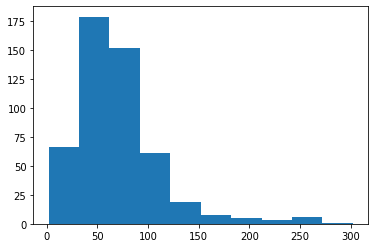

In [736]:
plt.hist([k['best_iteration'] for k in trials_lgb_sklearn.results])

In [729]:
trials_lgb_sklearn.results

[{'loss': -0.9435865595443031,
  'status': 'ok',
  'best_iteration': 87,
  'fitting_time': 0.9808897972106934},
 {'loss': -0.946839592635995,
  'status': 'ok',
  'best_iteration': 109,
  'fitting_time': 0.7656950950622559},
 {'loss': -0.9470737814854218,
  'status': 'ok',
  'best_iteration': 218,
  'fitting_time': 0.8237478733062744},
 {'loss': -0.92443129602878,
  'status': 'ok',
  'best_iteration': 2,
  'fitting_time': 0.23621439933776855},
 {'loss': -0.9479463945184581,
  'status': 'ok',
  'best_iteration': 81,
  'fitting_time': 0.6115548610687256},
 {'loss': -0.9468527441280319,
  'status': 'ok',
  'best_iteration': 62,
  'fitting_time': 0.5104634761810303},
 {'loss': -0.9444974734137974,
  'status': 'ok',
  'best_iteration': 41,
  'fitting_time': 0.787714958190918},
 {'loss': -0.9468838923986452,
  'status': 'ok',
  'best_iteration': 99,
  'fitting_time': 0.5745210647583008},
 {'loss': -0.9469877199673566,
  'status': 'ok',
  'best_iteration': 84,
  'fitting_time': 0.6395807266235

In [718]:
space_eval(ho_space_lgb_sklearn, best_lgb_sklearn)

{'clf_params': {'boost_from_average ': False,
  'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 0.8182516389037054,
  'importance_type': 'split',
  'learning_rate': 0.1,
  'max_depth': -1,
  'metric': 'auc',
  'min_child_samples': 20,
  'min_child_weight': 16.52386620023695,
  'min_split_gain': 0.0,
  'n_estimators': 10000,
  'n_jobs': -1,
  'num_leaves': 2341,
  'objective': 'binary',
  'random_state': 42,
  'reg_alpha': 3.891218174977137,
  'reg_lambda': 0.9174813885363191,
  'scale_pos_weight': 8.1426941252076,
  'subsample': 0.9266328090502111,
  'subsample_for_bin': 20000,
  'subsample_freq': 1},
 'fit_params': {'early_stopping_rounds': 'naotausando'}}

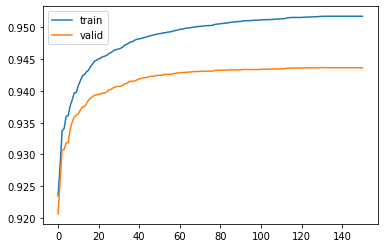

In [345]:
plt.plot(a.evals_result_['train']['auc'])
plt.plot(a.evals_result_['valid']['auc'])
plt.legend(['train', 'valid'])

finite loss range -0.6219520216581438 -0.0 -0.6137666494797192


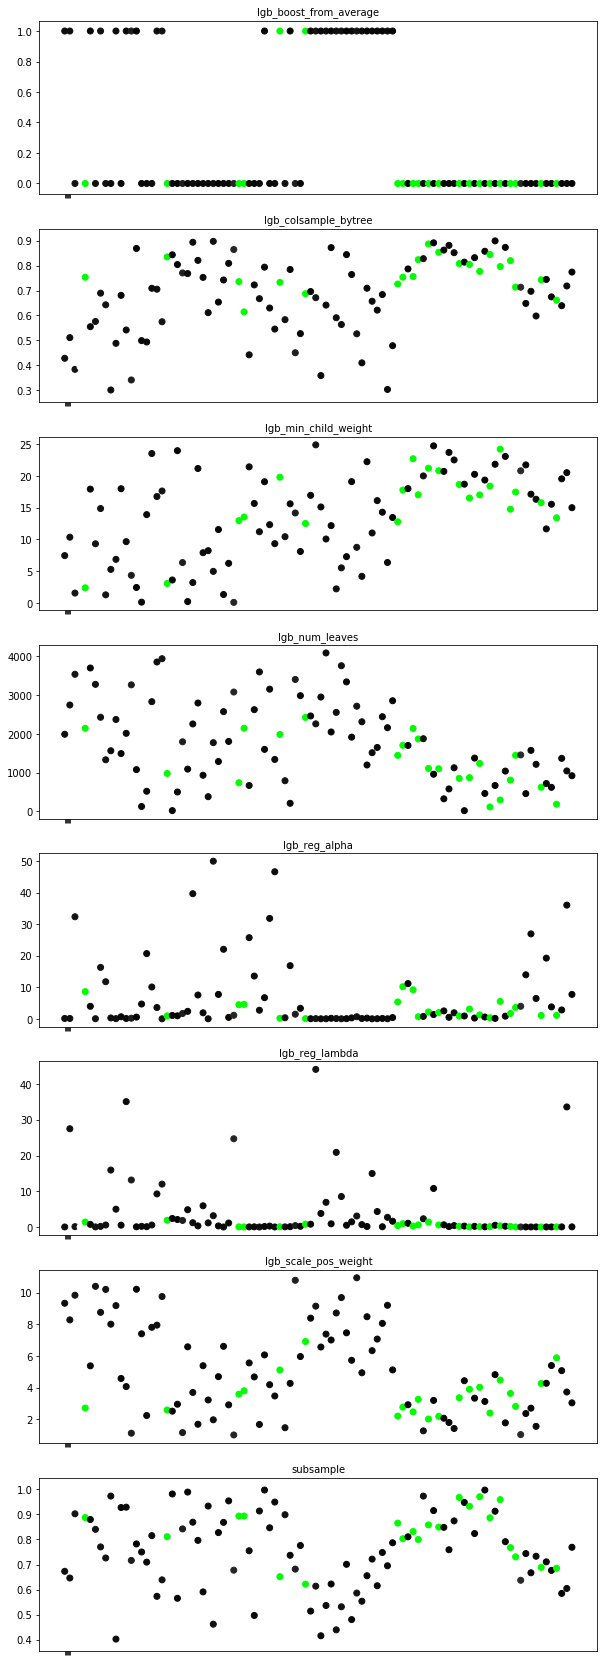

Showing Histogram of 100 jobs


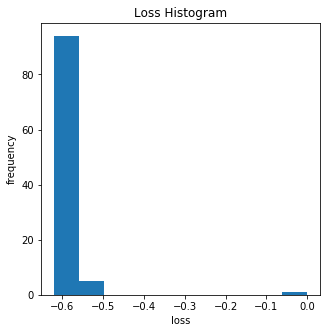

avg best error: -0.6219520216581438


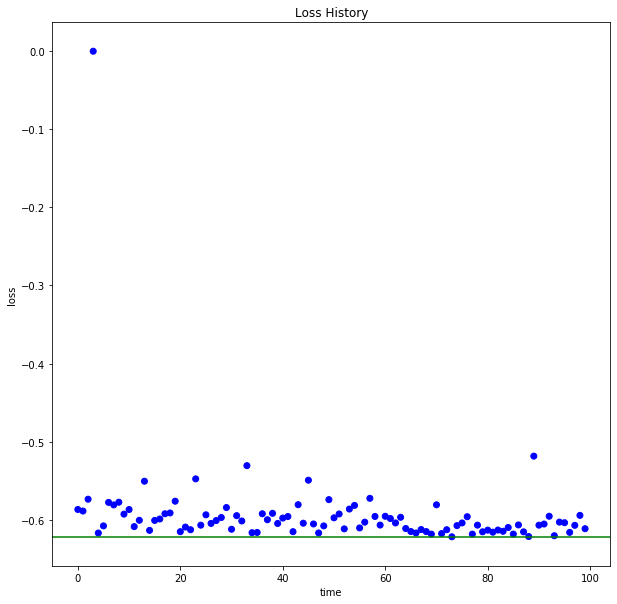

In [634]:
from hyperopt import plotting as ho_plotting
plt.figure(figsize=(10,30))
ho_plotting.main_plot_vars(trials_lgb_sklearn, colorize_best=20, columns=1, arrange_by_loss=False)

plt.figure(figsize=(5,5))
ho_plotting.main_plot_histogram(trials_lgb_sklearn)

plt.figure(figsize=(10,10))
ho_plotting.main_plot_history(trials_lgb_sklearn)

In [737]:
partest = space_eval(ho_space_lgb_sklearn, best_lgb_sklearn)['clf_params']
partest

{'boost_from_average ': False,
 'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.8182516389037054,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_child_samples': 20,
 'min_child_weight': 16.52386620023695,
 'min_split_gain': 0.0,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 2341,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 3.891218174977137,
 'reg_lambda': 0.9174813885363191,
 'scale_pos_weight': 8.1426941252076,
 'subsample': 0.9266328090502111,
 'subsample_for_bin': 20000,
 'subsample_freq': 1}

In [752]:
params_treino = {k:partest[k] for k in partest.keys() if k != 'n_estimators'}
a = lgb.LGBMClassifier(**params_treino, silent=False, n_estimators=trials_lgb_sklearn.best_trial['result']['best_iteration'])
a.fit(X_train, y_train, verbose=1, eval_set=[(X_train, y_train), (X_test, y_test)])

[1]	training's auc: 0.93968	valid_1's auc: 0.933359
[2]	training's auc: 0.946592	valid_1's auc: 0.941323
[3]	training's auc: 0.947625	valid_1's auc: 0.942583
[4]	training's auc: 0.948784	valid_1's auc: 0.943057
[5]	training's auc: 0.949285	valid_1's auc: 0.943941
[6]	training's auc: 0.949976	valid_1's auc: 0.943919
[7]	training's auc: 0.950591	valid_1's auc: 0.943993
[8]	training's auc: 0.952011	valid_1's auc: 0.945157
[9]	training's auc: 0.953551	valid_1's auc: 0.945167
[10]	training's auc: 0.954406	valid_1's auc: 0.945462
[11]	training's auc: 0.955118	valid_1's auc: 0.945988
[12]	training's auc: 0.955989	valid_1's auc: 0.945894
[13]	training's auc: 0.956754	valid_1's auc: 0.946502
[14]	training's auc: 0.957171	valid_1's auc: 0.946664
[15]	training's auc: 0.957432	valid_1's auc: 0.946792
[16]	training's auc: 0.957894	valid_1's auc: 0.946963
[17]	training's auc: 0.958586	valid_1's auc: 0.947295
[18]	training's auc: 0.959125	valid_1's auc: 0.947246
[19]	training's auc: 0.959585	valid_1'

LGBMClassifier(boost_from_average =False, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8182516389037054,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               metric='auc', min_child_samples=20,
               min_child_weight=16.52386620023695, min_split_gain=0.0,
               n_estimators=65, n_jobs=-1, num_leaves=2341, objective='binary',
               random_state=42, reg_alpha=3.891218174977137,
               reg_lambda=0.9174813885363191, scale_pos_weight=8.1426941252076,
               silent=False, subsample=0.9266328090502111,
               subsample_for_bin=20000, subsample_freq=1)

In [753]:
from sklearn.preprocessing import KBinsDiscretizer
n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# Fita bins no treino
binner.fit(a.predict_proba(X_train)[:,1].reshape(-1,1))

# Cria df com bins no treino e no teste
df_bins = pd.DataFrame(range(n_bins), columns=['bin'])
for X, y, label in [(X_train, y_train, 'train'), (X_test, y_test, 'test')]:
    tmp_df = pd.DataFrame()
    tmp_df['bin'] = binner.transform(a.predict_proba(X)[:,1].reshape(-1,1)).ravel()
    tmp_df['y'] = y.ravel()
    tmp_df = tmp_df.groupby('bin')['y'].agg(['mean', 'size']).reset_index()
    tmp_df.columns = ['_'.join([x, label]) if x != 'bin' else 'bin' for x in tmp_df.columns]
    df_bins = df_bins.merge(tmp_df, how='left')

del X,y, label, tmp_df

display(df_bins)

,bin,mean_train,size_train,mean_test,size_test
0,0,0.000000,3295,0.000000,792
1,1,0.000000,3295,0.000000,806
2,2,0.000000,3295,0.000000,822
3,3,0.000000,3295,0.000000,805
4,4,0.000000,3295,0.001230,813
5,5,0.000000,3295,0.005910,846
6,6,0.000303,3295,0.019185,834
7,7,0.014264,3295,0.107438,847
8,8,0.339101,3294,0.335624,873
9,9,0.770631,3296,0.661250,800


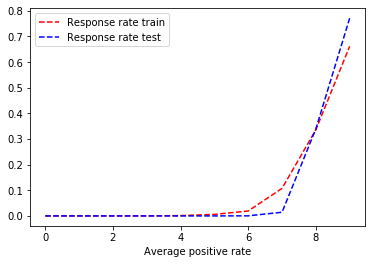

In [754]:
plt.plot(df_bins['bin'], df_bins['mean_test'], '--r')
plt.plot(df_bins['bin'], df_bins['mean_train'], '--b')
plt.legend(['Response rate train', 'Response rate test'])
plt.xlabel('Bin')
plt.xlabel('Average positive rate')

plt.show()

C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


(array([7.92291351, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 2.07708649]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

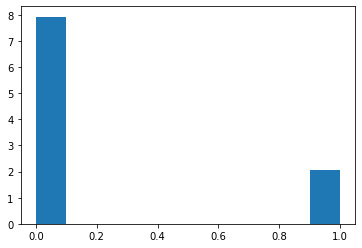

In [755]:
plt.hist(a.predict(X_train, num_iteration=1000), normed=True)

In [744]:
from sklearn.metrics import cohen_kappa_score, f1_score, classification_report, matthews_corrcoef

In [769]:
print('cohen_kappa train lgbm', cohen_kappa_score(a.predict(X_train), y_train))
print('cohen_kappa test lgbm ', cohen_kappa_score(a.predict(X_test), y_test))
print('cohen_kappa train lgbm + logreg', cohen_kappa_score(lr.predict(leaves_encoded), y_train))
print('cohen_kappa test lgbm + logreg', cohen_kappa_score(lr.predict(leaves_encoded_test), y_test))

cohen_kappa train lgbm 0.6440573693667087
cohen_kappa test lgbm  0.5609698208738291
cohen_kappa train lgbm + logreg 0.5741388412382045
cohen_kappa test lgbm + logreg 0.5203501472646717


In [770]:
print('matthews_corrcoef train lgbm', matthews_corrcoef(y_train, a.predict(X_train)))
print('matthews_corrcoef test lgbm ', matthews_corrcoef(y_test, a.predict(X_test)))
print('matthews_corrcoef train lgbm + logreg', matthews_corrcoef(y_train, lr.predict(leaves_encoded)))
print('matthews_corrcoef test lgbm + logreg', matthews_corrcoef(y_test, lr.predict(leaves_encoded_test)))

matthews_corrcoef train lgbm 0.6871061645305935
matthews_corrcoef test lgbm  0.599584032744207
matthews_corrcoef train lgbm + logreg 0.5766805244283822
matthews_corrcoef test lgbm + logreg 0.5237354217275421


In [771]:
print('f1_binary', f1_score(y_train, a.predict(X_train), average='binary'))
print('f1_micro', f1_score(y_train, a.predict(X_train), average='micro'))
print('f1_macro', f1_score(y_train, a.predict(X_train), average='macro'))
print('f1_weighted', f1_score(y_train, a.predict(X_train), average='weighted'))

f1_binary 0.6959901412456158
f1_micro 0.9026707132018209
f1_macro 0.8190254043114494
f1_weighted 0.9143917356832671


In [772]:
print('----- train lgbm')
print(classification_report(y_train, a.predict(X_train)))
print('----- test lgbm')
print(classification_report(y_test, a.predict(X_test)))

print('----- train lgbm + logreg')
print(classification_report(y_train, lr.predict(leaves_encoded)))
print('----- test lgbm + logreg')
print(classification_report(y_test, lr.predict(leaves_encoded_test)))


----- train lgbm
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     29245
           1       0.54      0.99      0.70      3705

    accuracy                           0.90     32950
   macro avg       0.77      0.94      0.82     32950
weighted avg       0.95      0.90      0.91     32950

----- test lgbm
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      7303
           1       0.48      0.90      0.63       935

    accuracy                           0.88      8238
   macro avg       0.73      0.89      0.78      8238
weighted avg       0.93      0.88      0.89      8238

----- train lgbm + logreg
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     29245
           1       0.67      0.57      0.62      3705

    accuracy                           0.92     32950
   macro avg       0.81      0.77      0.79     32950
weighted avg   

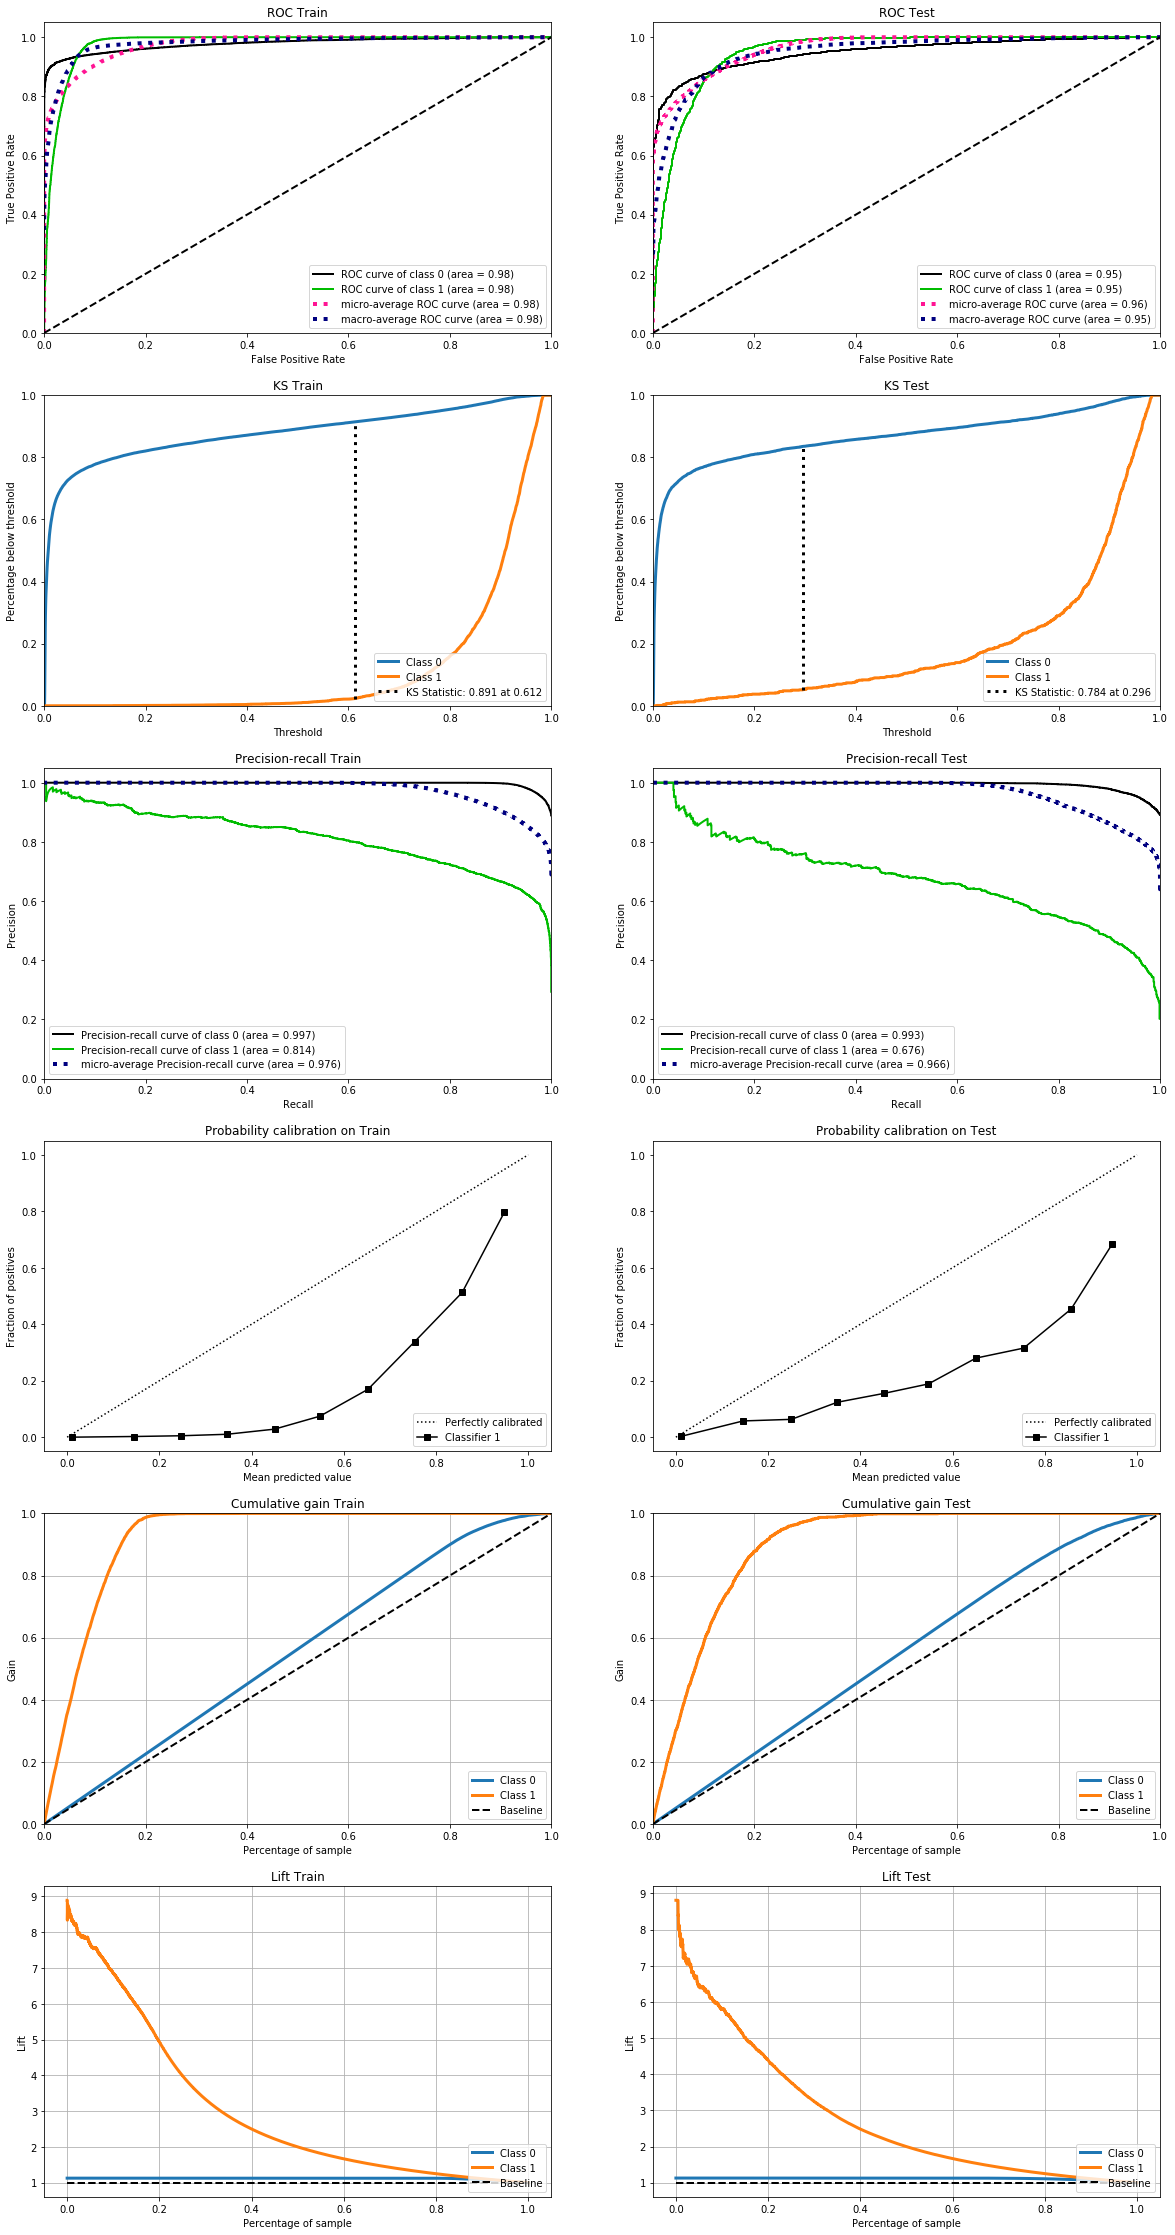

In [760]:
plots_skplt_classification(a, (X_train, y_train, 'Train'), (X_test, y_test, 'Test'))

In [849]:
# Treino
leaves = a.predict(X_train, pred_leaf=True)
encoder = OneHotEncoder(categories='auto')
leaves_encoded = encoder.fit_transform(leaves)
leaves_encoded
# lr = LogisticRegression(solver='sag', C=10**(-3), fit_intercept=False, n_jobs=-1)
# lr = LogisticRegression(solver='saga', C=10**(-1), fit_intercept=False, penalty='l1', max_iter=500, n_jobs=-1)
lr = LogisticRegression(solver='saga', C=10**(-2), fit_intercept=False, penalty='elasticnet', max_iter=500, n_jobs=-1, l1_ratio=0.5)
lr.fit(leaves_encoded, y_train)

# Aplica no teste
leaves_test = a.predict(X_test, pred_leaf=True)
leaves_encoded_test = encoder.transform(leaves_test)

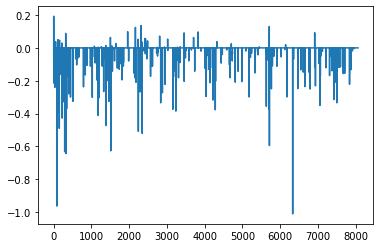

In [850]:
plt.plot(lr.coef_[0])

(array([2.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 6.000e+00, 2.400e+01,
        3.800e+01, 9.500e+01, 7.885e+03, 9.000e+00]),
 array([-1.01199781, -0.89151182, -0.77102583, -0.65053984, -0.53005384,
        -0.40956785, -0.28908186, -0.16859587, -0.04810988,  0.07237611,
         0.19286211]),
 <a list of 10 Patch objects>)

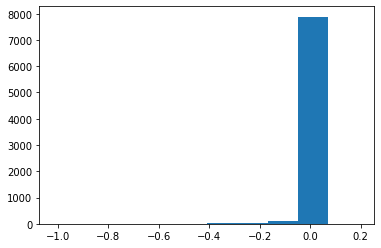

In [851]:
plt.hist(lr.coef_[0])

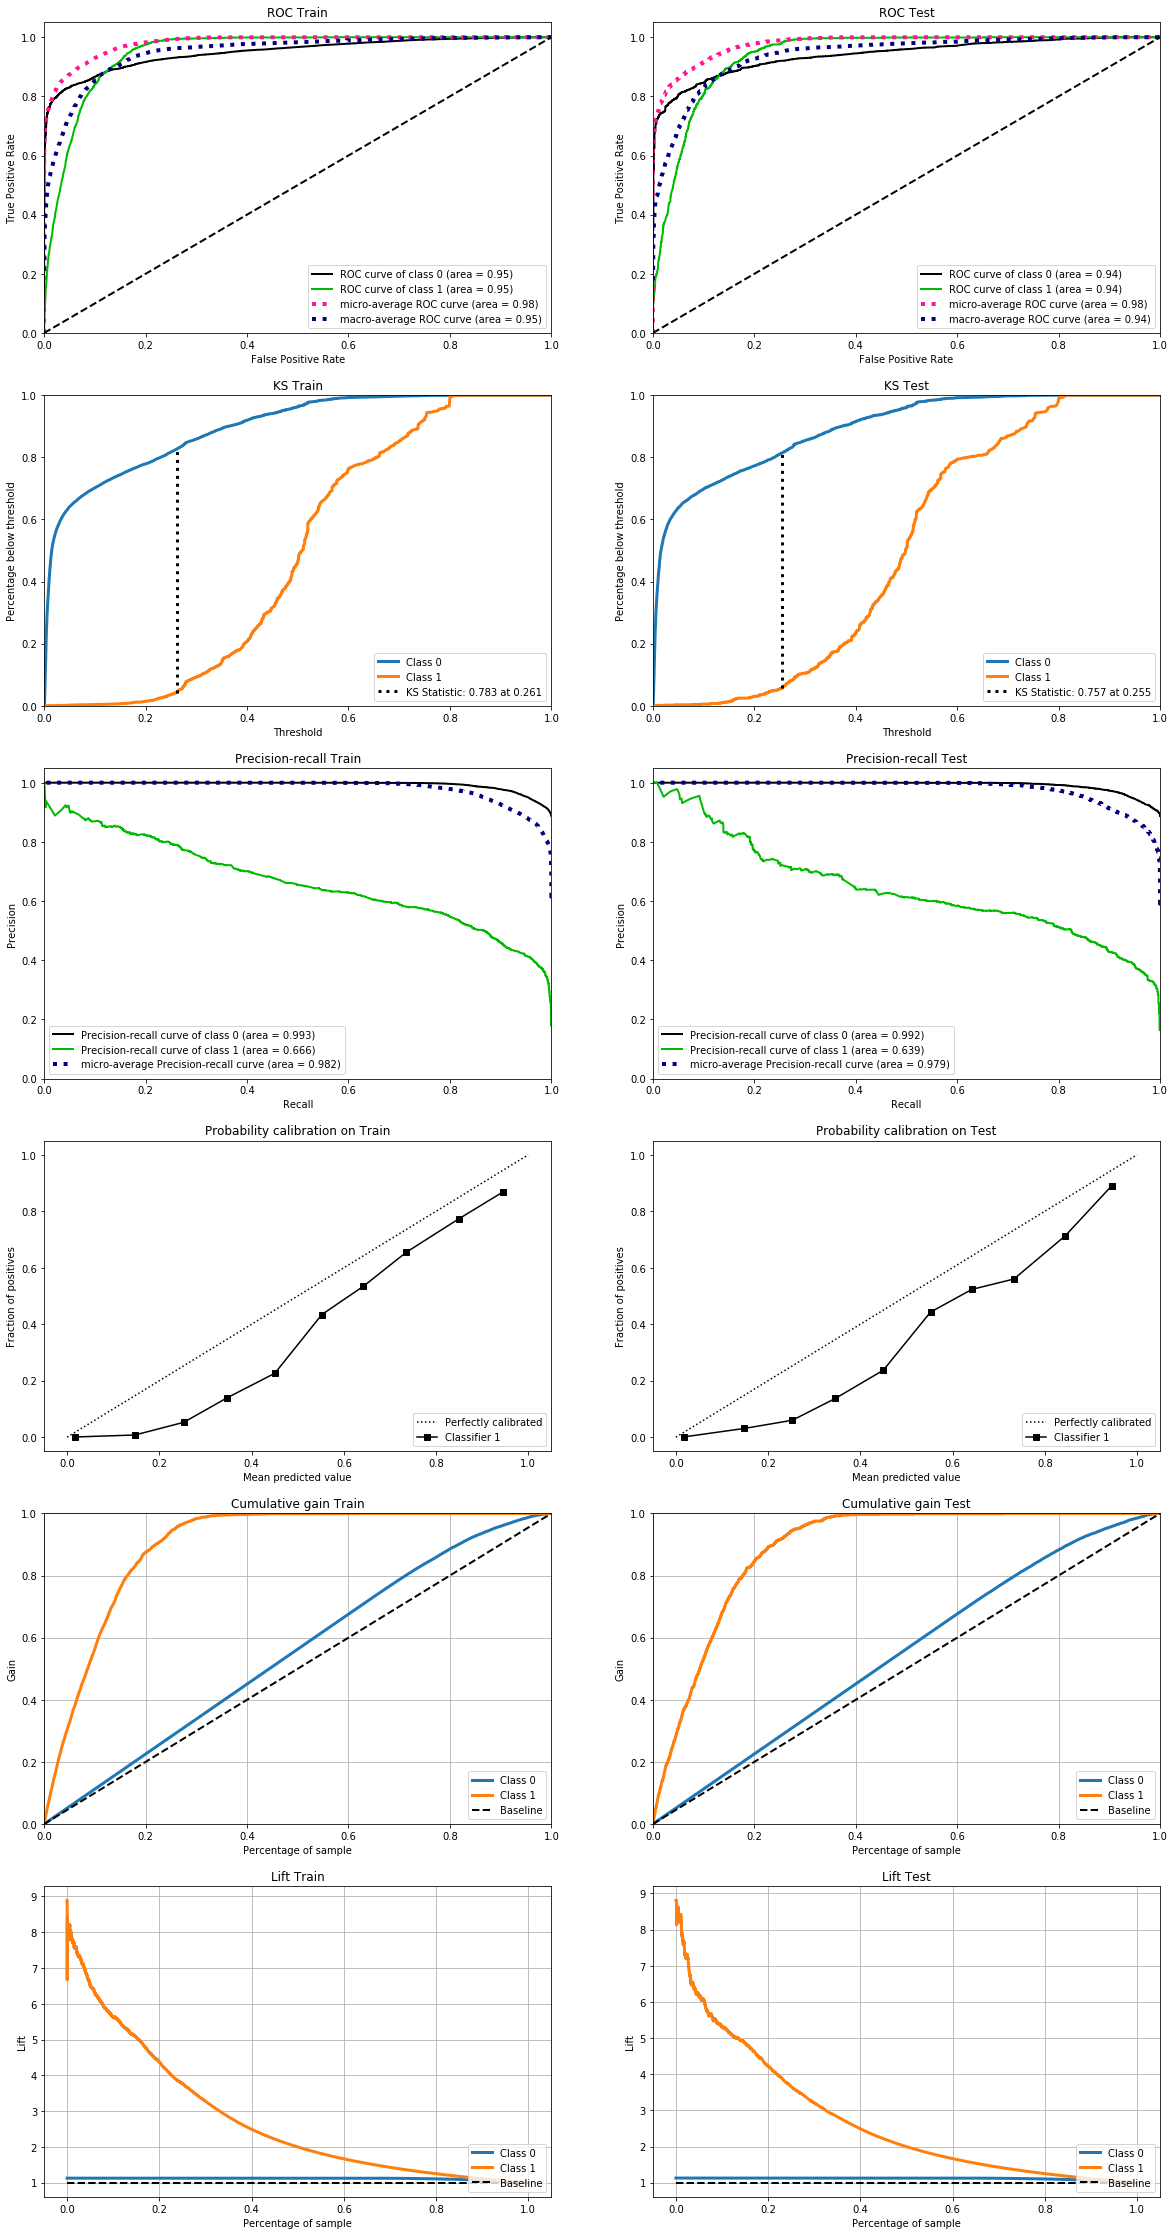

In [852]:
plots_skplt_classification(lr, (leaves_encoded, y_train, 'Train'), (leaves_encoded_test, y_test, 'Test'))

In [798]:
n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# Fita bins no treino
binner.fit(lr.predict_proba(leaves_encoded)[:,1].reshape(-1,1))

# Cria df com bins no treino e no teste
df_bins = pd.DataFrame(range(n_bins), columns=['bin'])
for X, y, label in [(leaves_encoded, y_train, 'train'), (leaves_encoded_test, y_test, 'test')]:
    tmp_df = pd.DataFrame()
    tmp_df['bin'] = binner.transform(lr.predict_proba(X)[:,1].reshape(-1,1)).ravel()
    tmp_df['y'] = y.ravel()
    tmp_df = tmp_df.groupby('bin')['y'].agg(['mean', 'size']).reset_index()
    tmp_df.columns = ['_'.join([x, label]) if x != 'bin' else 'bin' for x in tmp_df.columns]
    df_bins = df_bins.merge(tmp_df, how='left')

# del X,y, label, tmp_df

display(df_bins)

C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


,bin,mean_train,size_train,mean_test,size_test
0,0,0.000000,22962.0,0.009556,5651.0
1,1,0.000000,3397.0,0.111602,905.0
2,2,0.124127,3295.0,0.400722,1108.0
3,3,1.000000,3296.0,0.585366,574.0
4,4,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN


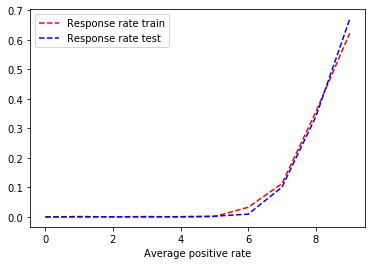

In [775]:
plt.plot(df_bins['bin'], df_bins['mean_test'], '--r')
plt.plot(df_bins['bin'], df_bins['mean_train'], '--b')
plt.legend(['Response rate train', 'Response rate test'])
plt.xlabel('Bin')
plt.xlabel('Average positive rate')

plt.show()

In [412]:
a = KBinsDiscretizer(n_bins=10, encode='onehot', strategy='quantile')
a.fit(X_train.select_dtypes(np.number))

C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1

KBinsDiscretizer(encode='onehot', n_bins=10, strategy='quantile')

# Randomized trees embedding + logistic

In [864]:
pipe_tree_linear = make_pipeline(
    ColumnTransformer([("get_cat_codes", get_cat_codes_transformer, cat_cols)], remainder='passthrough'),
    RandomTreesEmbedding(n_estimators=1000, max_depth=10, n_jobs=-1, min_samples_split = 50),
    LogisticRegression(solver='saga', C=10**(-2), fit_intercept=False, penalty='elasticnet', max_iter=500, n_jobs=-1, l1_ratio=0.5))


pipe_tree_linear.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('get_cat_codes',
                                                  FunctionTransformer(accept_sparse=False,
                                                                      check_inverse=True,
                                                                      func=<function get_cat_codes at 0x0000018D9F01AC18>,
                                                                      inv_kw_args=None,
                                                                      inverse_func=None,
                                                                      kw_args=None,
                                                                      pass_y='deprec...
                             

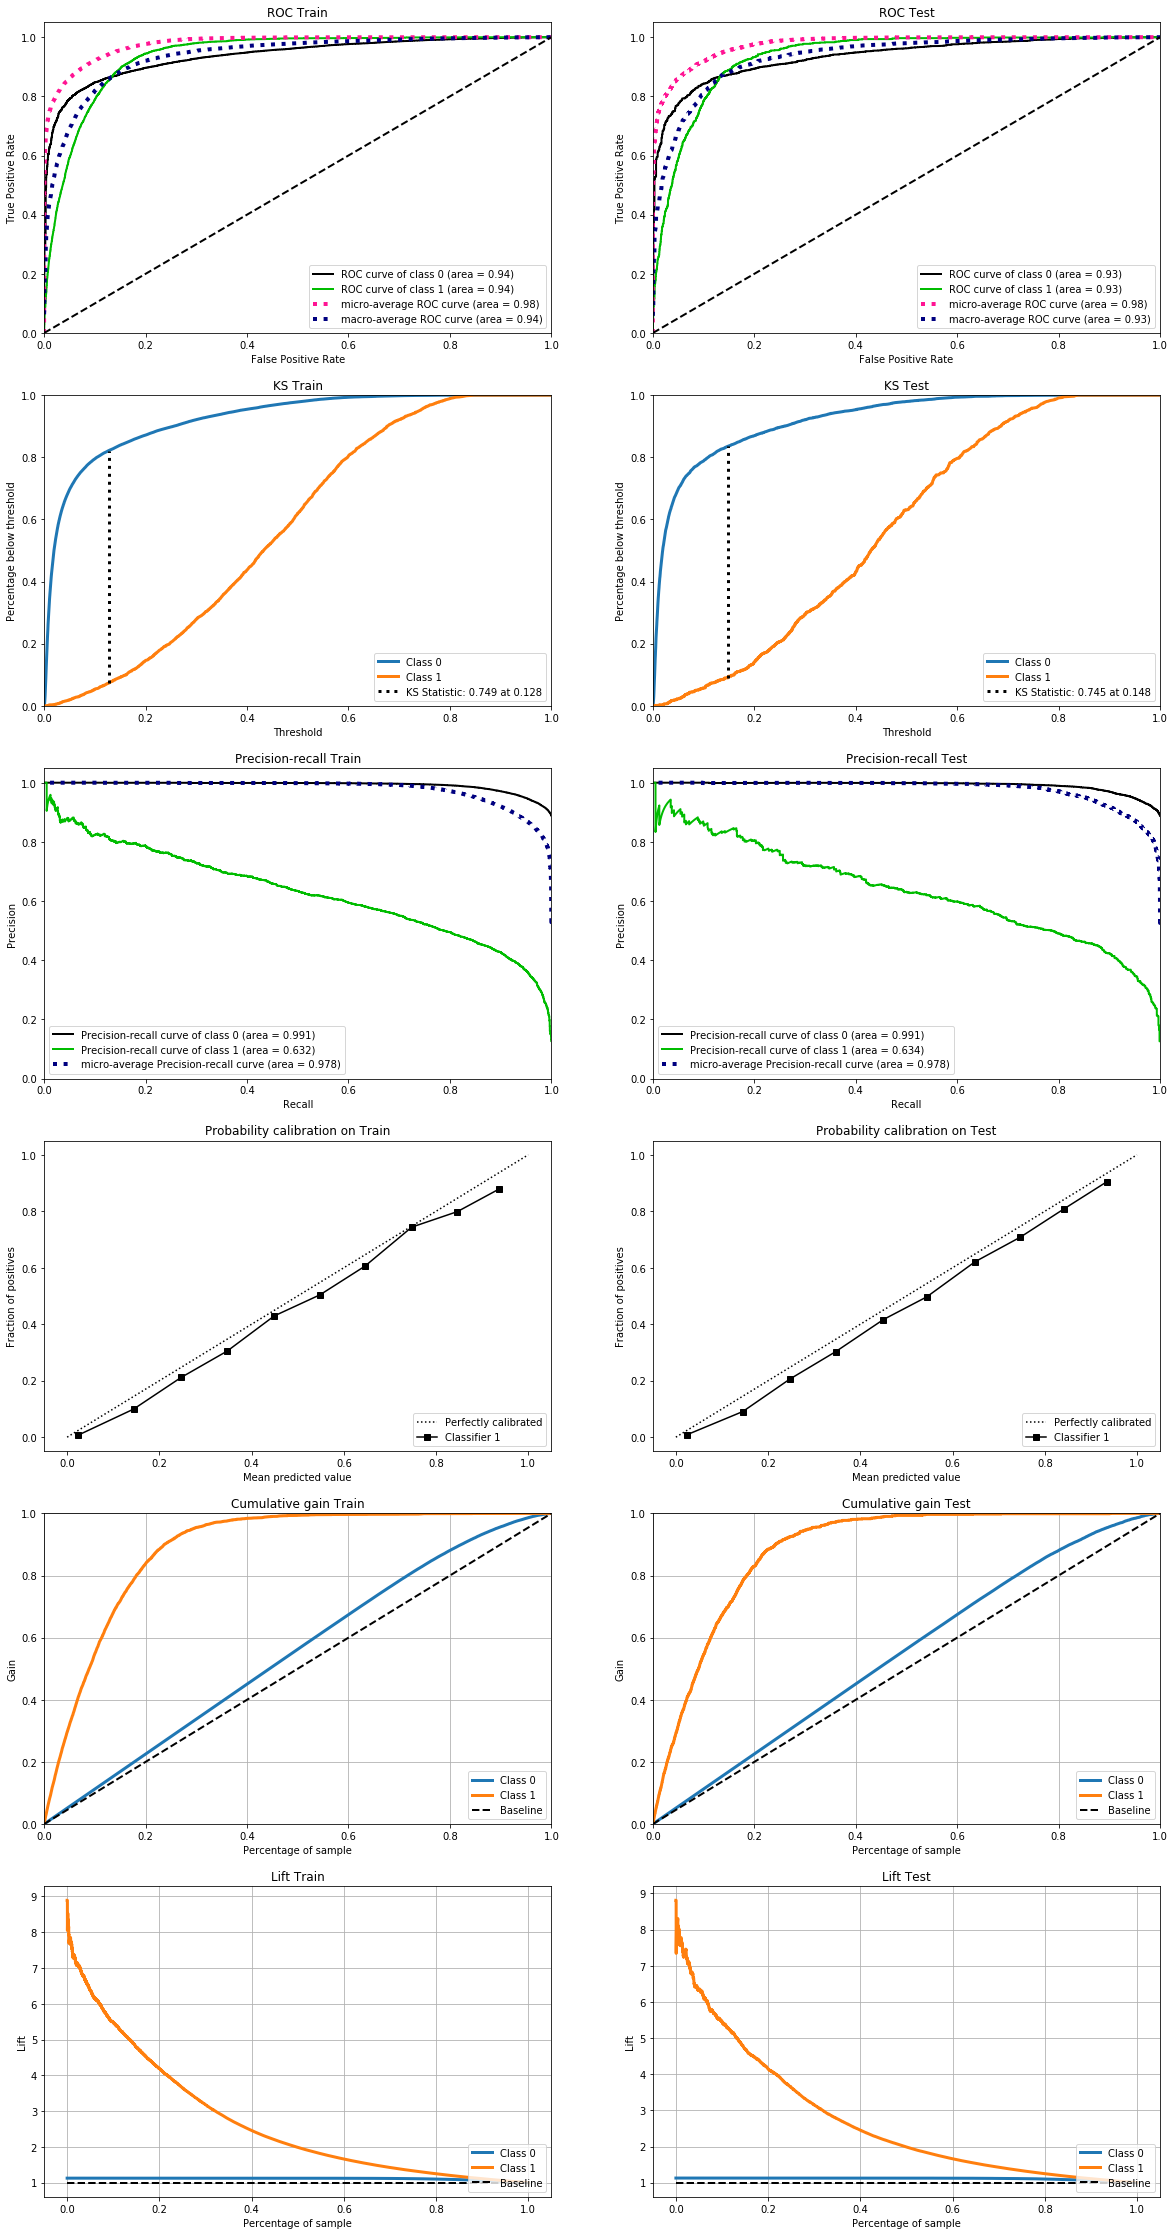

In [865]:
plots_skplt_classification(pipe_tree_linear, (X_train, y_train, 'Train'), (X_test, y_test, 'Test'))

In [866]:
print('----- train rte + logistic')
print(classification_report(y_train, pipe_tree_linear.predict(X_train)))
print('----- train rte + logistic')
print(classification_report(y_test, pipe_tree_linear.predict(X_test)))



----- train rte + logistic
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     29245
           1       0.69      0.38      0.49      3705

    accuracy                           0.91     32950
   macro avg       0.81      0.68      0.72     32950
weighted avg       0.90      0.91      0.90     32950

----- train rte + logistic
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7303
           1       0.70      0.37      0.48       935

    accuracy                           0.91      8238
   macro avg       0.81      0.67      0.72      8238
weighted avg       0.90      0.91      0.90      8238



,bin,mean_train,size_train,mean_test,size_test
0,0,0.000000,3295,0.001160,862
1,1,0.000607,3295,0.000000,829
2,2,0.002125,3294,0.000000,798
3,3,0.000910,3296,0.002463,812
4,4,0.003339,3294,0.003623,828
5,5,0.010922,3296,0.014616,821
6,6,0.033394,3294,0.038462,780
7,7,0.130765,3296,0.128571,840
8,8,0.325645,3295,0.319378,836
9,9,0.616692,3295,0.615385,832


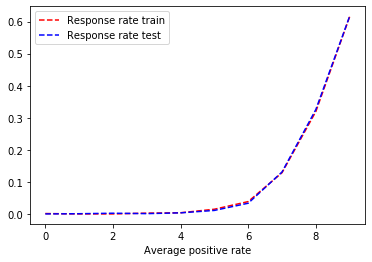

In [867]:
from sklearn.preprocessing import KBinsDiscretizer
n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# Fita bins no treino
binner.fit(pipe_tree_linear.predict_proba(X_train)[:,1].reshape(-1,1))

# Cria df com bins no treino e no teste
df_bins = pd.DataFrame(range(n_bins), columns=['bin'])
for X, y, label in [(X_train, y_train, 'train'), (X_test, y_test, 'test')]:
    tmp_df = pd.DataFrame()
    tmp_df['bin'] = binner.transform(pipe_tree_linear.predict_proba(X)[:,1].reshape(-1,1)).ravel()
    tmp_df['y'] = y.ravel()
    tmp_df = tmp_df.groupby('bin')['y'].agg(['mean', 'size']).reset_index()
    tmp_df.columns = ['_'.join([x, label]) if x != 'bin' else 'bin' for x in tmp_df.columns]
    df_bins = df_bins.merge(tmp_df, how='left')

del X,y, label, tmp_df

display(df_bins)

plt.plot(df_bins['bin'], df_bins['mean_test'], '--r')
plt.plot(df_bins['bin'], df_bins['mean_train'], '--b')
plt.legend(['Response rate train', 'Response rate test'])
plt.xlabel('Bin')
plt.xlabel('Average positive rate')

plt.show()

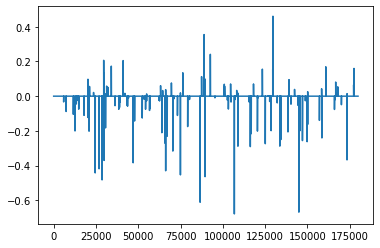

In [911]:
plt.plot(pipe_tree_linear.steps[-1][1].coef_[0])

# Vanilla Logistic regression

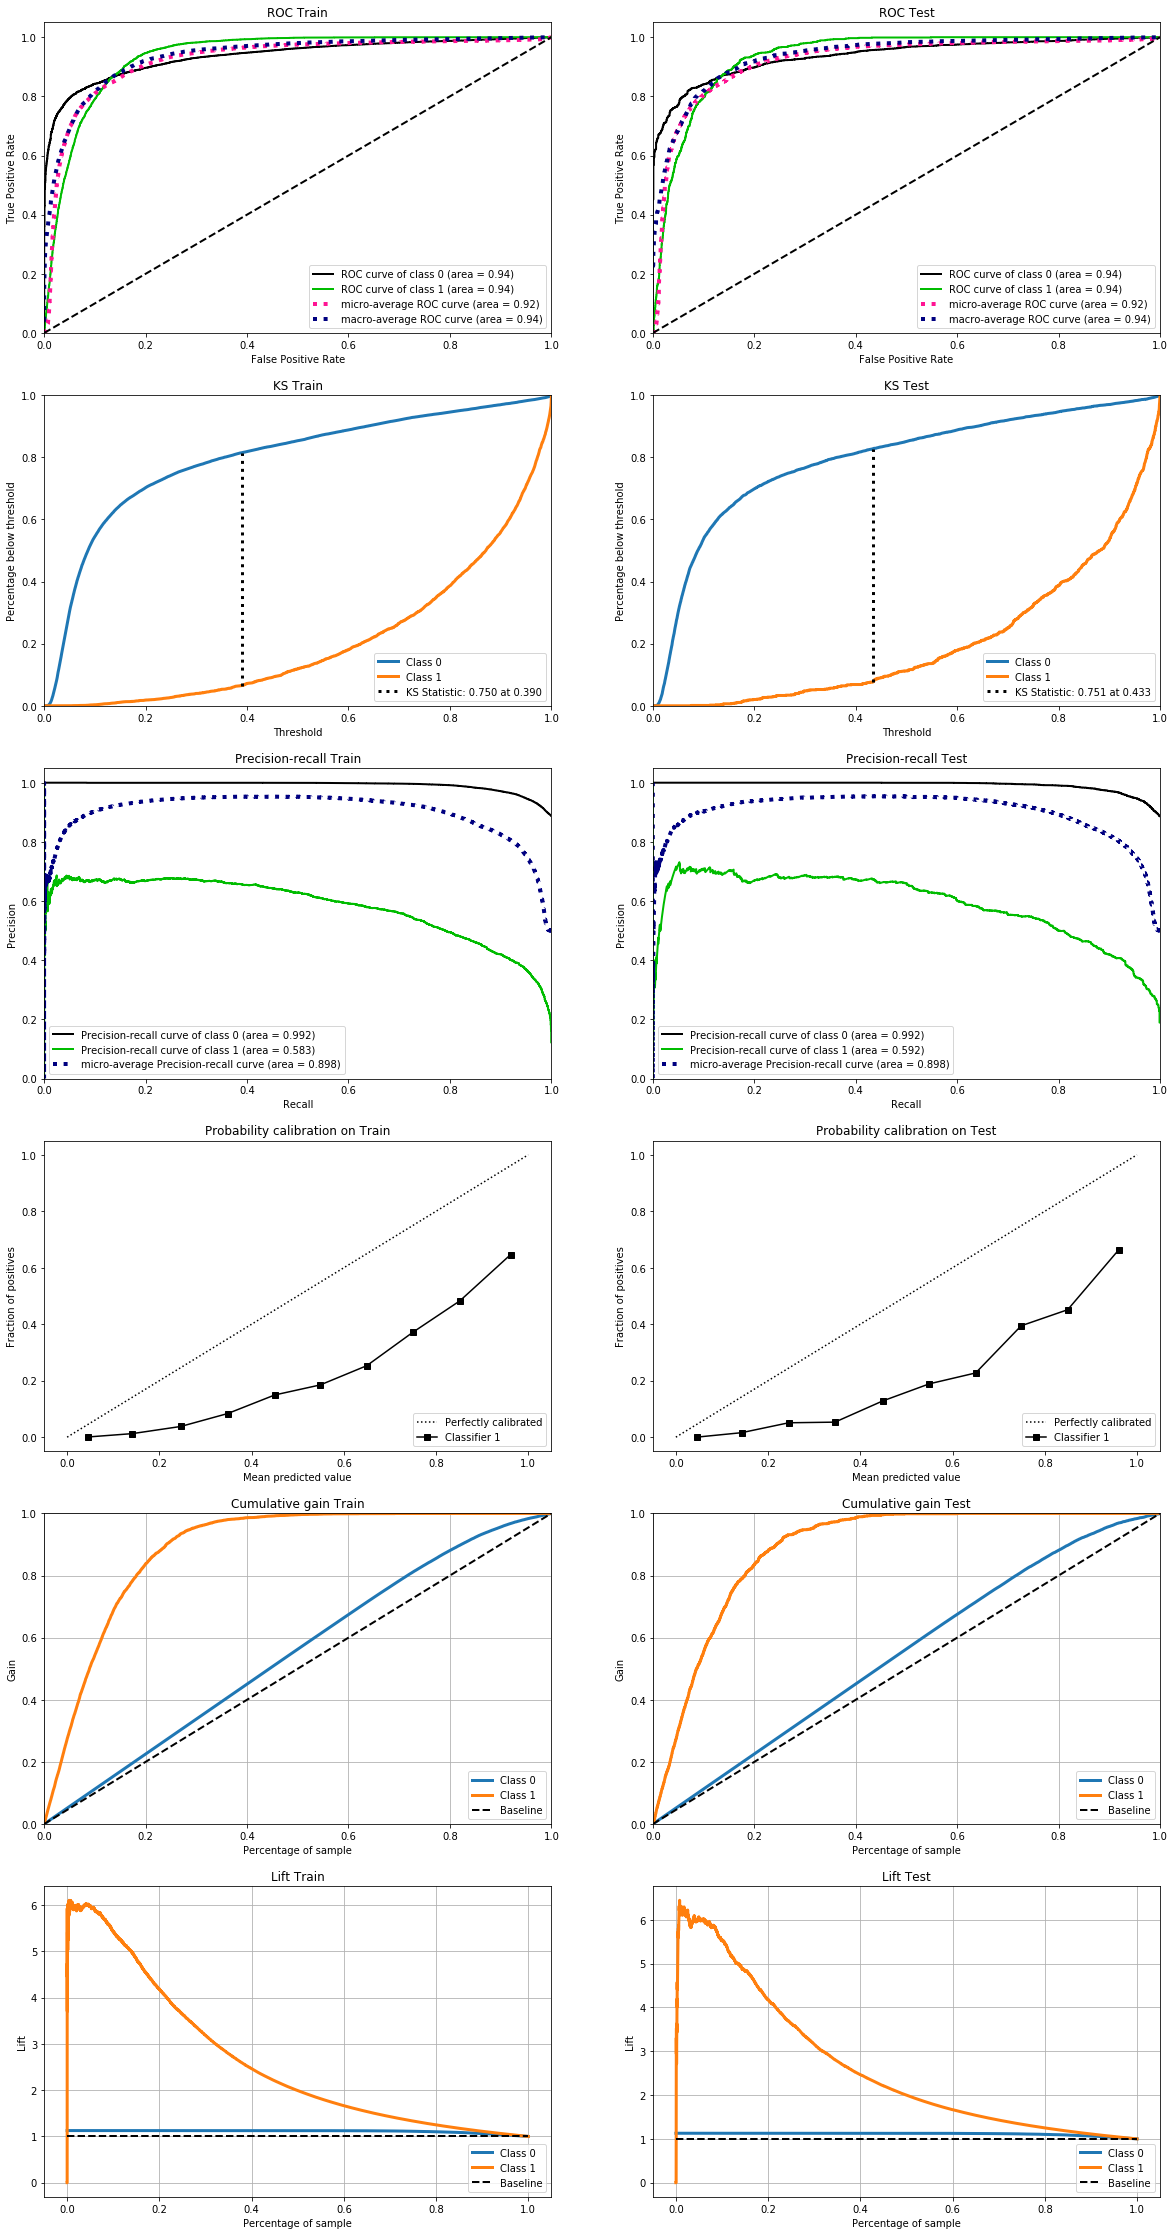

----- train rte + logistic
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     29245
           1       0.43      0.88      0.58      3705

    accuracy                           0.86     32950
   macro avg       0.71      0.87      0.75     32950
weighted avg       0.92      0.86      0.88     32950

----- train rte + logistic
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7303
           1       0.43      0.89      0.58       935

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.87      8238



,bin,mean_train,size_train,mean_test,size_test
0,0,0.000304,3294,0.000000,828
1,1,0.000000,3296,0.000000,818
2,2,0.000000,3295,0.000000,804
3,3,0.001214,3295,0.000000,820
4,4,0.003035,3295,0.001269,788
5,5,0.011229,3295,0.010727,839
6,6,0.034294,3295,0.045838,829
7,7,0.133273,3294,0.120141,849
8,8,0.330400,3296,0.318616,838
9,9,0.610622,3295,0.627879,825


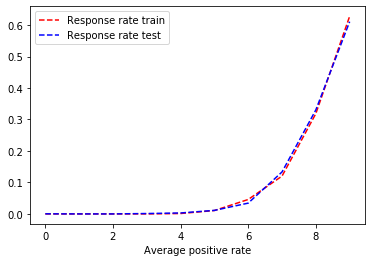

In [883]:
logreg_pipeline = make_pipeline(
    ColumnTransformer([("get_cat_codes", make_pipeline(get_cat_codes_transformer, OneHotEncoder(categories='auto')), cat_cols),
                      ("sd_numeric", StandardScaler(), num_cols)
                      ], remainder='drop'),
    LogisticRegression(solver='saga', C=10**(-2), fit_intercept=True, penalty='elasticnet', class_weight='balanced'
                       , max_iter=500, n_jobs=-1, l1_ratio=0.5))


logreg_pipeline.fit(X_train, y_train)

plots_skplt_classification(logreg_pipeline, (X_train, y_train, 'Train'), (X_test, y_test, 'Test'))

print('----- train vanilla logistic')
print(classification_report(y_train, logreg_pipeline.predict(X_train)))
print('----- train vanilla logistic')
print(classification_report(y_test, logreg_pipeline.predict(X_test)))

from sklearn.preprocessing import KBinsDiscretizer
n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# Fita bins no treino
binner.fit(logreg_pipeline.predict_proba(X_train)[:,1].reshape(-1,1))

# Cria df com bins no treino e no teste
df_bins = pd.DataFrame(range(n_bins), columns=['bin'])
for X, y, label in [(X_train, y_train, 'train'), (X_test, y_test, 'test')]:
    tmp_df = pd.DataFrame()
    tmp_df['bin'] = binner.transform(logreg_pipeline.predict_proba(X)[:,1].reshape(-1,1)).ravel()
    tmp_df['y'] = y.ravel()
    tmp_df = tmp_df.groupby('bin')['y'].agg(['mean', 'size']).reset_index()
    tmp_df.columns = ['_'.join([x, label]) if x != 'bin' else 'bin' for x in tmp_df.columns]
    df_bins = df_bins.merge(tmp_df, how='left')

del X,y, label, tmp_df

display(df_bins)

plt.plot(df_bins['bin'], df_bins['mean_test'], '--r')
plt.plot(df_bins['bin'], df_bins['mean_train'], '--b')
plt.legend(['Response rate train', 'Response rate test'])
plt.xlabel('Bin')
plt.xlabel('Average positive rate')

plt.show()

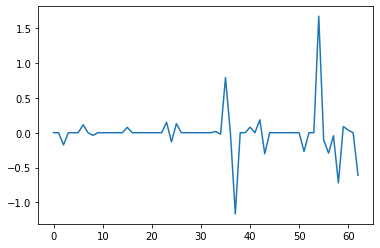

In [910]:
plt.plot(logreg_pipeline.steps[-1][1].coef_[0])

# Binning + OneHot + logistic

C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 2 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
C:\Users\T-Gamer\Anaconda3\envs\sklearn_novo_2\lib\site-packages\sklearn\preprocessing\_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1

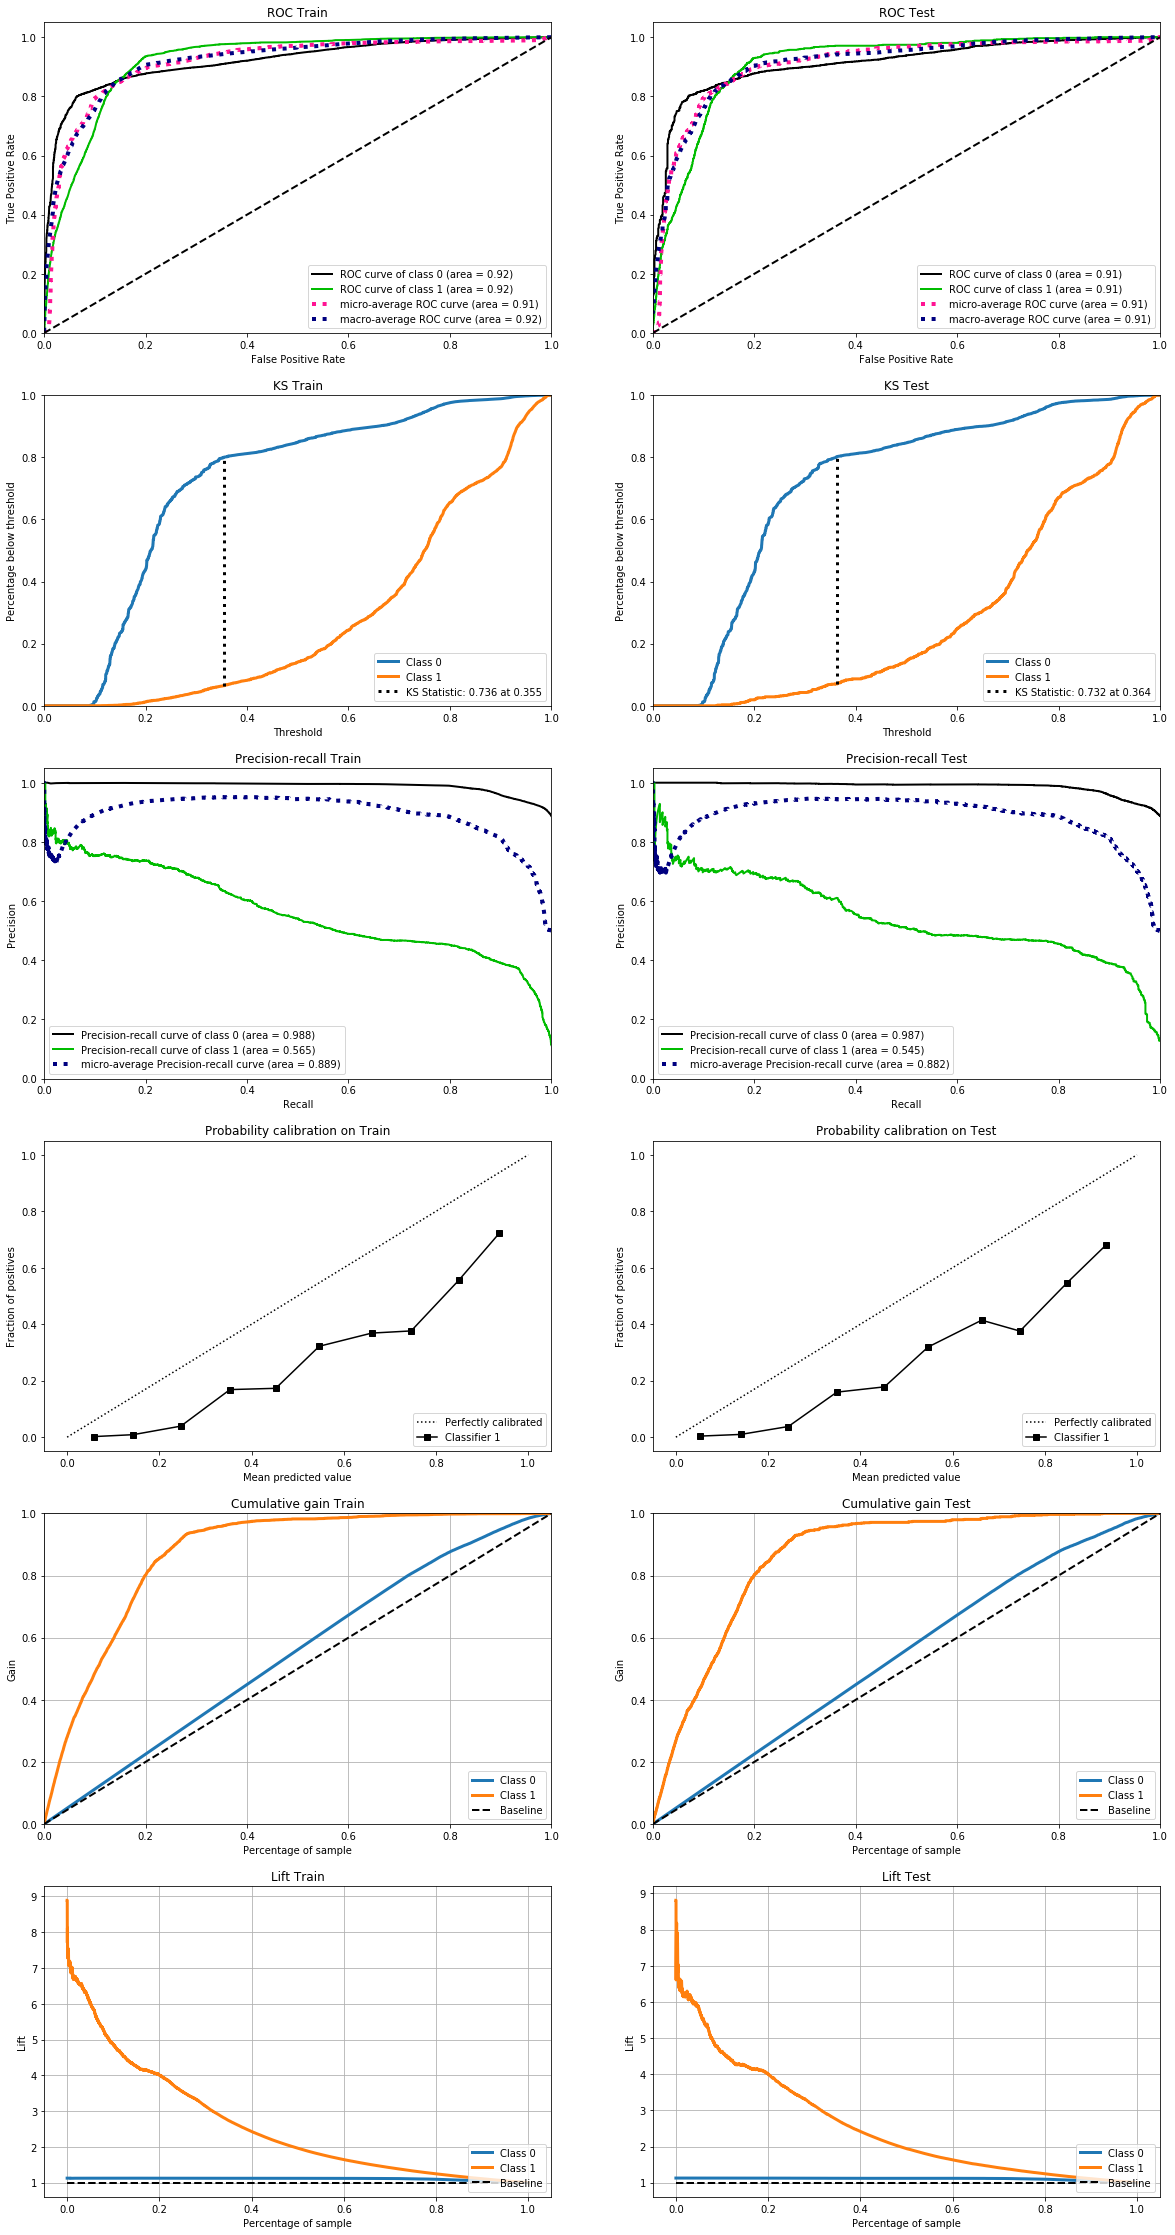

----- train rte + logistic
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     29245
           1       0.43      0.88      0.58      3705

    accuracy                           0.86     32950
   macro avg       0.71      0.87      0.75     32950
weighted avg       0.92      0.86      0.88     32950

----- train rte + logistic
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7303
           1       0.43      0.89      0.58       935

    accuracy                           0.86      8238
   macro avg       0.71      0.87      0.75      8238
weighted avg       0.92      0.86      0.87      8238



,bin,mean_train,size_train,mean_test,size_test
0,0,0.000920,3260,0.000000,853
1,1,0.001203,3325,0.003650,822
2,2,0.003943,3297,0.008674,807
3,3,0.008490,3298,0.011905,756
4,4,0.005535,3252,0.009401,851
5,5,0.010827,3325,0.003690,813
6,6,0.034848,3300,0.030197,861
7,7,0.156970,3300,0.155985,827
8,8,0.353869,3295,0.383578,816
9,9,0.546998,3298,0.525240,832


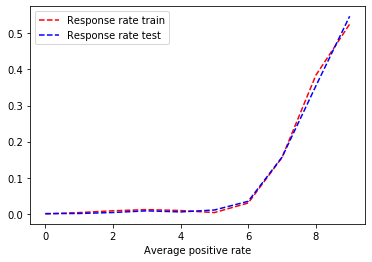

In [929]:
bin_oht_logreg = make_pipeline(
    ColumnTransformer([("get_cat_codes", make_pipeline(get_cat_codes_transformer, OneHotEncoder(categories='auto')), cat_cols),
                      ("sd_numeric", KBinsDiscretizer(n_bins=10, encode='onehot', strategy='quantile'), num_cols)
                      ], remainder='drop'),
    LogisticRegression(solver='saga', C=10**(-2), fit_intercept=True, penalty='elasticnet', class_weight='balanced'
                       , max_iter=500, n_jobs=-1, l1_ratio=0.5)
)
bin_oht_logreg.fit(X_train, y_train)


bin_oht_logreg.fit(X_train, y_train)

plots_skplt_classification(bin_oht_logreg, (X_train, y_train, 'Train'), (X_test, y_test, 'Test'))

print('----- train rte + logistic')
print(classification_report(y_train, logreg_pipeline.predict(X_train)))
print('----- train rte + logistic')
print(classification_report(y_test, logreg_pipeline.predict(X_test)))

n_bins = 10
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
# Fita bins no treino
binner.fit(bin_oht_logreg.predict_proba(X_train)[:,1].reshape(-1,1))

# Cria df com bins no treino e no teste
df_bins = pd.DataFrame(range(n_bins), columns=['bin'])
for X, y, label in [(X_train, y_train, 'train'), (X_test, y_test, 'test')]:
    tmp_df = pd.DataFrame()
    tmp_df['bin'] = binner.transform(bin_oht_logreg.predict_proba(X)[:,1].reshape(-1,1)).ravel()
    tmp_df['y'] = y.ravel()
    tmp_df = tmp_df.groupby('bin')['y'].agg(['mean', 'size']).reset_index()
    tmp_df.columns = ['_'.join([x, label]) if x != 'bin' else 'bin' for x in tmp_df.columns]
    df_bins = df_bins.merge(tmp_df, how='left')

del X,y, label, tmp_df

display(df_bins)

plt.plot(df_bins['bin'], df_bins['mean_test'], '--r')
plt.plot(df_bins['bin'], df_bins['mean_train'], '--b')
plt.legend(['Response rate train', 'Response rate test'])
plt.xlabel('Bin')
plt.xlabel('Average positive rate')

plt.show()

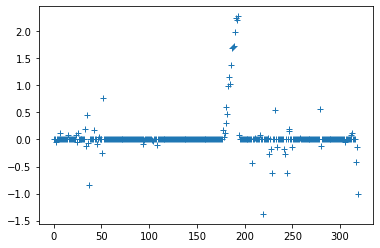

In [934]:
plt.plot(bin_oht_logreg.steps[-1][1].coef_[0], '+')

In [935]:
binner.bin_edges_

array([array([0.08370694, 0.12388128, 0.1482217 , 0.17547317, 0.20182851,
       0.22151095, 0.2548983 , 0.33449877, 0.56500016, 0.75540165,
       0.99319738])], dtype=object)

In [939]:
num_cols

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [955]:
bin_oht_logreg.steps[-2][1].named_transformers_['get_cat_codes'].steps[-1][-1].categories_

[array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int8),
 array([-1,  0,  1,  2], dtype=int8),
 array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int8),
 array([-1,  0,  1], dtype=int8),
 array([-1,  0,  1], dtype=int8),
 array([-1,  0,  1], dtype=int8),
 array([0, 1], dtype=int8),
 array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int8),
 array([0, 1, 2, 3, 4], dtype=int8),
 array([-1,  0,  1], dtype=int8)]

In [960]:
bin_oht_logreg.steps[-2][1].named_transformers_['sd_numeric'].n_bins_

array([ 41, 100,  11,   4,   3,   8,  19,  17,  55,   9])